In [1]:
import json
import numpy as np
from typing import Any, Callable, List, Optional, Tuple, Dict

class RBCAgent:
    def __init__(self, 
                    obs_keys: List[str], # ['soc', 'price', 'net_load', 'solar_generation']
                    action_space: List[str], # ['charge', 'discharge', 'idle'] 
                    rule_defs: List[Dict] = None, 
                    # e.g. [
                    #   {
                    #     "conditions": [
                    #       {"field":"soc","op":"<","threshold_name":"soc_low"}
                    #     ],
                    #     "action":"charge"
                    #   }
                    # ]
                    thresholds: Dict[str, float] = None, # {'soc': 0.2, 'price': 50.0}
                    history: List[Tuple[Dict[str, float], str, float]] = None, # [(observation_dict, action_str, reward_float)]
                    obs_index_map: Optional[Dict[str, int]] = None):   # <--- NEW (optional)
        self.obs_keys = obs_keys
        self.action_space = action_space
        self.rule_defs = rule_defs or []
        self.thresholds = thresholds or {}
        self.history = history or []
        self.rewards = []
        self.obs_index_map = obs_index_map or {}                   # <--- NEW

        # Initialize rules from dictionaries
        self.rules = [(self.make_rule_fn(rule), rule["action"]) for rule in self.rule_defs]

    def set_obs_index_map(self, mapping: Dict[str, int]):          
        self.obs_index_map = dict(mapping)

    def _ensure_obs_map(self, env):                                 
        if self.obs_index_map:
            return
        names = getattr(env.buildings[0], "active_observations", None)
        if not names:
            raise RuntimeError(
                "obs_index_map missing and env has no observation_names. "
                "Call agent.set_obs_index_map({'soc': i, 'price': j, 'net_load': k, 'solar_generation': m})."
            )
        name_to_idx = {n: i for i, n in enumerate(names)}
        # default aliases
        wanted = {
            "soc": "electrical_storage_soc",
            "price": "electricity_pricing",
            "net_load": "net_electricity_consumption",  # or 'non_shiftable_load'
            "solar_generation": "solar_generation",
        }
        try:
            self.obs_index_map = {k: name_to_idx[wanted[k]] for k in self.obs_keys}
        except KeyError as e:
            raise RuntimeError(
                f"Could not auto-map {e}. "
                f"Available names include: {names[:20]} ..."
            )
    
    def add_rule(self, rule: dict):
        self.rule_defs.append(rule)
        cond_fn = self.make_rule_fn(rule)
        self.rules.append((cond_fn, rule['action']))
    
    def add_threshold(self, name: str, value: float):
        self.thresholds[name] = value
    
    def make_rule_fn(self, rule: Dict[str, Any]) -> Callable[[Dict[str, float]], bool]:
        """
        Create a condition function based on the rule dictionary.
        """
        cond_fns = []
        for cond in rule["conditions"]:
            field, op, threshold_name = cond["field"], cond["op"], cond["threshold_name"]
            if field not in self.obs_keys:
                raise ValueError(f"Field '{field}' not found in observation keys.")
            if threshold_name not in self.thresholds:
                raise ValueError(f"Threshold name '{threshold_name}' not found in thresholds.")
            if op == "<": cond_fns.append(lambda obs, f=field, t=threshold_name: obs[f] < self.thresholds[t])
            elif op == "<=": cond_fns.append(lambda obs, f=field, t=threshold_name: obs[f] <= self.thresholds[t])
            elif op == ">": cond_fns.append(lambda obs, f=field, t=threshold_name: obs[f] > self.thresholds[t])
            elif op == ">=": cond_fns.append(lambda obs, f=field, t=threshold_name: obs[f] >= self.thresholds[t])
            else: raise ValueError(f"Unsupported operator: {op}")
        return lambda obs: all(fn(obs) for fn in cond_fns)
    
    def act(self, observation)-> str:
        """
        Determine the action to take based on the current observation.
        If no rules match, return "idle".
        """
        for condition, action in self.rules:
            if condition(observation):
                return action
        return "idle"
    
    def save(self, filename="rbc_agent.json"):
        agent_state = {
            'obs_keys': self.obs_keys,
            'action_space': self.action_space,
            'rules': self.rule_defs,
            'thresholds': self.thresholds,
            'history': self.history,
        }
        with open(filename, "w") as f:
            json.dump(agent_state, f, indent=2)
    
    def load(self, filename="rbc_agent.json"):
        with open(filename, "r") as f:
            state = json.load(f)
        self.obs_keys = state['obs_keys']
        self.action_space = state['action_space']
        self.thresholds = state['thresholds']
        self.history = state['history']
        self.rule_defs = state['rules']
        # Rebuild rules from dictionaries
        self.rules = [
            (self.make_rule_fn(rule), rule['action']) for rule in self.rule_defs
        ]
    
    def fmt6(self, x):  # round for display
        return f"{float(x):.6f}"

    def evaluate(self, env, broadcast=False,  max_steps=None) -> Tuple[float, List[Tuple[Dict[str, float], str, float]]]:
        """
        Evaluate the agent for one episode in the given environment.
        Returns (episode_reward, episode_history),
        where episode_history is a list of (obs_dict, action_str, step_reward).
        """
        env.reset()
        self._ensure_obs_map(env)
        episode_history = []
        episode_reward = 0.0
        steps = 0

        done = False
        while not done and (max_steps is None or steps < max_steps):
            # 1) Observations for all buildings -> take building 0 only
            obs_all = env.observations            # List[List[float]]
            obs_vec  = obs_all[0]                         # features of building 0
            #obs_dict = {k: float(b0[i]) for i, k in enumerate(self.obs_keys)}
            obs_dict = {k: float(obs_vec [self.obs_index_map[k]]) for k in self.obs_keys}

            # control the soc
            b0 = env.buildings[0]
            ts = b0.time_step
            obs_soc = b0.electrical_storage.soc[0] if ts == 0 else b0.electrical_storage.soc[ts-1]
            obs_dict['soc'] = float(obs_soc)

            # get the net_load
            names = env.buildings[0].active_observations
            obs_dict['net_load'] = max(
                0.0,
                float(obs_vec[names.index('non_shiftable_load')] - obs_vec[names.index('solar_generation')])
            )

            # 2) Decide action for building 0
            action = self.act(obs_dict)

            # map the string action to numeric fractions for each storage
            # charge → +1.0, idle → 0.0, discharge → -1.0
            frac = {"charge": 1.0, "idle": 0.0, "discharge": -1.0}[action]
            
            # 3) Build central-agent action list: control b0, zeros elsewhere
            N = env.action_space[0].shape[0]

            if broadcast:
                actions = [[float(np.clip(frac, -1.0, 1.0))] * N]
            else:
                flat = [0.0] * N
                flat[0] = float(np.clip(frac, -1.0, 1.0))
                actions = [flat]

            # 4) Step the env and unpack
            obs_all, reward_list, terminated, truncated, _ = env.step(actions)

            # 5) Use only building 0's reward
            step_reward = float(reward_list[0])

            # 6) Log + accumulate
            fmt_obs = {k: self.fmt6(v) for k, v in obs_dict.items()}
            print(f"{fmt_obs}, {action}, {self.fmt6(step_reward)}")

            #print(f"{obs_dict}, {action}, {step_reward}")
            episode_history.append((obs_dict, action, step_reward))
            self.history.append((obs_dict, action, step_reward))

            episode_reward += step_reward
            done = bool(terminated) or bool(truncated)

            steps += 1

        return episode_reward, episode_history
    
    def multiple_evaluation(self, env, episodes=10) -> Tuple[float, float]:
        """
        Evaluate the agent over multiple episodes and return the mean and std of rewards.
        """
        self.rewards = []
        for _ in range(episodes):
            episode_reward, _ = self.evaluate(env)
            self.rewards.append(episode_reward)
        return np.mean(self.rewards), np.std(self.rewards)

In [2]:
import os, json, re
import pandas as pd
from citylearn.data import DataSet
from citylearn.citylearn import CityLearnEnv

def keep_only_electrical_storage(schema: dict) -> dict: # Set actions to just electical storage
    # Top-level actions
    if 'actions' in schema:
        for a in list(schema['actions'].keys()):
            schema['actions'][a]['active'] = (a == 'electrical_storage')

    # Per-building overrides, if present
    if 'buildings' in schema:
        for b in schema['buildings']:
            if 'actions' in b:
                for a in list(b['actions'].keys()):
                    b['actions'][a]['active'] = (a == 'electrical_storage')
    return schema

"""
# rule_defs e.g. [
#   {
#     "conditions": [
#       {"field":"soc","op":"<","threshold_name":"soc_low"}
#     ],
#     "action":"charge"
#   }
# ]
"""
dataset = DataSet()
schema = dataset.get_schema('citylearn_challenge_2023_phase_3_1')
schema['root_directory'] = r'/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1'
schema = keep_only_electrical_storage(schema) # Activate only the electrical storage control (fix "Expected 18 actions but got 1")
schema['reward_function'] = { # CostReward Function
    'type': 'citylearn.reward_function.CostReward',
    'attributes': {}
}
price_file = 'pricing_germany_2023_june_to_august.csv'  # Pricing CSV

if 'buildings' not in schema:
    raise RuntimeError("schema does not contain 'buildings' (make sure schema is loaded first)")
for bname, bconf in schema['buildings'].items():
    bconf['pricing'] = price_file

env = CityLearnEnv(schema, central_agent=True) 
agent = RBCAgent(obs_keys=['soc', 'price', 'net_load', 'solar_generation'],
                 action_space=['charge', 'discharge', 'idle'],
                 rule_defs=[
                     {"conditions": [{"field": "soc", "op": "<", "threshold_name": "soc_low"}], "action": "charge"},
                     {"conditions": [{"field": "soc", "op": ">", "threshold_name": "soc_high"}], "action": "discharge"}
                 ],
                 thresholds={'soc_low': 0.45, 'soc_high': 0.55, 'price': 0.15, 'net_load': 6.0},
                 history=[])
# -----------------------------------------



# ---------------------------------
"""
0: day_type
1: hour
2: outdoor_dry_bulb_temperature
3: outdoor_dry_bulb_temperature_predicted_1
4: outdoor_dry_bulb_temperature_predicted_2
5: outdoor_dry_bulb_temperature_predicted_3
6: diffuse_solar_irradiance
7: diffuse_solar_irradiance_predicted_1
8: diffuse_solar_irradiance_predicted_2
9: diffuse_solar_irradiance_predicted_3
10: direct_solar_irradiance
11: direct_solar_irradiance_predicted_1
12: direct_solar_irradiance_predicted_2
13: direct_solar_irradiance_predicted_3
14: carbon_intensity
15: indoor_dry_bulb_temperature
16: non_shiftable_load
17: solar_generation
18: dwh_storage_soc
19: electrical_storage_soc
20: net_electricity_consumption
21: electricity_pricing
22: electricity_pricing_predicted_1
23: electricity_pricing_predicted_2
24: electricity_pricing_predicted_3
25: cooling demand
26: dwh demand
27: occupant count
28: power_outage
29: indoor_dry_bulb_temperature_cooling_set_point
"""

# evaluate 1 episode
r, hist = agent.evaluate(env, max_steps=500)  # max steps while debugging

# build logs from 'hist'
logs = [{'timestep': t, **obs, 'action': action, 'reward': reward} for t, (obs, action, reward) in enumerate(hist)]
df = pd.DataFrame(logs, columns=['timestep','soc','price','net_load','solar_generation','action','reward'])
df.to_csv('rbc_agent_logs.csv', index=False)

# Debug
print('Reward function:', type(env.reward_function).__name__)
print(env.schema['buildings'][env.buildings[0].name]['pricing'])

Couldn't import dot_parser, loading of dot files will not be possible.


INFO:root:Go here /home/iai/cj9272/.cache/citylearn/v2.4.1/datasets/citylearn_challenge_2023_phase_3_1/schema.json 


/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1
Dataset '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1' copied to '/hkfs/home/haicore/iai/cj9272/Bachelorthesis_DQN_Agent/data/datasets/citylearn_challenge_2023_phase_3_1/../../../../results/2025-08-18_15-12-42'
{'soc': '0.200000', 'price': '0.084150', 'net_load': '0.356269', 'solar_generation': '0.000000'}, charge, -1.196428
{'soc': '0.961749', 'price': '0.074300', 'net_load': '0.344522', 'solar_generation': '0.000000'}, discharge, -0.204986
{'soc': '0.599879', 'price': '0.070100', 'net_load': '0.338227', 'solar_generation': '0.000000'}, discharge, -0.266068
{'soc': '0.202774', 'price': '0.066720', 'net_load': '0.334329', 'solar_generation': '0.000000'}, charge, -0.410361
{'soc': '0.961892', 'price': '0.067700', 'net_load': '0.348094', 'solar_generation': '0.000000'}, discharge, -0.197599
{'soc': '0.600468', 'price': '0.08045

In [7]:
# Validate that observed net_electricity_consumption now matches internal raw value
# (Run AFTER applying the index fix; run again before fix to see mismatches.)

import math

# Fresh reset
env.reset()
b0 = env.buildings[0]
names = b0.active_observations
idx_net = names.index('net_electricity_consumption')

print(f"{'step':>4} {'b_time':>6} {'obs_net':>12} {'raw_curr':>12} {'diff':>10}")
print("-"*60)

mismatches = 0
rows = 15  # adjust if needed

for step in range(rows):
    # No-op central action (all zeros)
    N = env.action_space[0].shape[0]
    actions = [[0.0]*N]
    obs_all, reward_list, terminated, truncated, _ = env.step(actions)

    bt = b0.time_step                 # time_step AFTER this step
    obs_net = obs_all[0][idx_net]     # value exposed in observation
    raw_curr = b0.net_electricity_consumption[bt-1]  # internal just-computed value
    diff = obs_net - raw_curr

    print(f"{step:4d} {bt:6d} {obs_net:12.6f} {raw_curr:12.6f} {diff:10.6f}")

    # Simple tolerance check
    if not math.isclose(obs_net, raw_curr, rel_tol=1e-6, abs_tol=1e-8):
        mismatches += 1

    if terminated or truncated:
        break

print(f"\nMismatches: {mismatches} out of {step+1} printed steps.")
if mismatches == 0:
    print("Validation PASSED: obs_net aligns with raw internal net.")
else:
    print("Validation FAILED: obs_net still misaligned (apply or re-check fix).")

step b_time      obs_net     raw_curr       diff
------------------------------------------------------------
   0      1     1.246832     1.246832   0.000000
   1      2     0.556836     0.556836   0.000000
   2      3     0.423126     0.423126   0.000000
   3      4     0.362121     0.362121   0.000000
   4      5     0.369513     0.369513   0.000000
   5      6     0.750610     0.750610   0.000000
   6      7     1.373667     1.373667   0.000000
   7      8     0.161215     0.161215   0.000000
   8      9     4.043299     4.043299   0.000000
   9     10    -0.088245    -0.088245   0.000000
  10     11    -0.641126    -0.641126   0.000000
  11     12     1.143084     1.143084   0.000000
  12     13    -0.489699    -0.489699   0.000000
  13     14    -0.762066    -0.762066   0.000000
  14     15    -0.428157    -0.428157   0.000000

Mismatches: 0 out of 15 printed steps.
Validation PASSED: obs_net aligns with raw internal net.


In [4]:
logs = [{'timestep': i, **obs, 'action': a, 'reward': r} for i,(obs,a,r) in enumerate(agent.history)]
df = pd.DataFrame(logs, columns=['timestep','soc','price','net_load','solar_generation','action','reward'])
df.to_csv('rbc_agent_logs.csv', index=False)
print("Wrote:", os.path.abspath('rbc_agent_logs.csv'))

Wrote: /hkfs/home/haicore/iai/cj9272/rbc_agent_logs.csv


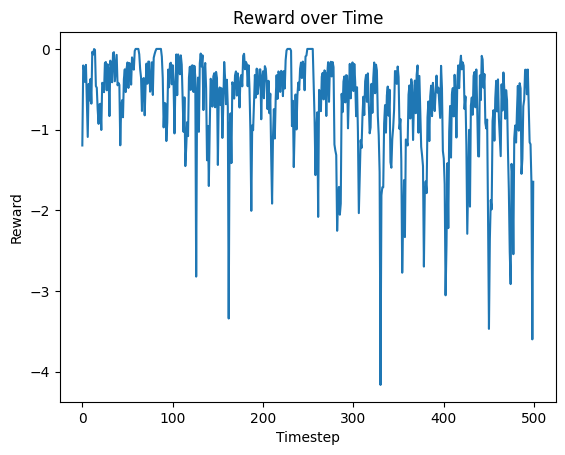

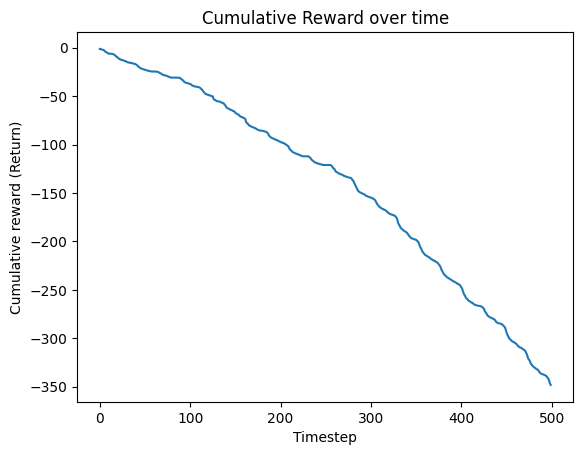

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Attempt to load the log data, handle if file is missing
try:
    df = pd.read_csv('rbc_agent_logs.csv')
except FileNotFoundError:
    print("Log file 'rbc_agent_logs.csv' not found.")
else:
    plt.figure()
    plt.plot(df['timestep'], df['reward'])
    plt.xlabel('Timestep')
    plt.ylabel('Reward')
    plt.title('Reward over Time')
    plt.show()

    df['cum_reward'] = df['reward'].cumsum()
    plt.figure()
    plt.plot(df['timestep'], df['cum_reward'])
    plt.xlabel('Timestep'); plt.ylabel('Cumulative reward (Return)'); plt.title('Cumulative Reward over time')
    plt.show()